## Comments on this Notebook:

This Notebook contains the modelling step of the task. The data that was used here was prepared beforehand in the Notebook "**04_predictive_analytics_data_prep**" .
The datasets were already generated. Therefore, you don't have to run the prep notebook. You can download the data that is needed for the modelling step under the following link: https://uni-koeln.sciebo.de/s/45E2vlQWAxGKcfy?path=%2FProjekt%20Ordner%20(Datens%C3%A4tze%2C%20Bilder%20etc.)%2Fdata

Download the folder "**04_predictive_analytics_data**" and put it into a folder name as "**data**".

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from dask_ml.model_selection import GridSearchCV 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from shapely.geometry import Polygon
from h3 import h3

## Helper functions

In [2]:
# Split and normalize data

def prep_data(df, h3=False, resolution=None, train_test_val_split=True, location_info=True):
    """
    Split and normalize data as well as create dummy variables.
    
    Parameters:
        df (pandas.DataFrame): The input DataFrame containing the data.
        h3 (bool, optional): Whether to consider H3 location information. Default is False.
        resolution (int, optional): The resolution of H3 geospatial data, if h3 is True. Default is None.
        train_test_val_split (bool, optional): Whether to split the data into training, validation, and test sets. 
                                               Default is True.
        location_info (bool, optional): Whether to include location information. 
                                        This parameter is only relevant when h3 is True. Default is True.
    
    Returns:
        tuple: A tuple containing the following elements in order:
            - X_train_norm (numpy.ndarray): Normalized training features data.
            - X_test_norm (numpy.ndarray): Normalized test features data.
            - X_val_norm (numpy.ndarray or None): Normalized validation features data if train_test_val_split is True,
                                                 otherwise, None.
            - y_train (pandas.Series): Training labels data.
            - y_test (pandas.Series): Test labels data.
            - y_val (pandas.Series or None): Validation labels data if train_test_val_split is True, otherwise, None.
            - X_train (pandas.DataFrame): Training features data before normalization.
            - X_test (pandas.DataFrame): Test features data before normalization.
            - X_val (pandas.DataFrame or None): Validation features data before normalization if train_test_val_split is True,
                                               otherwise, None.
    """
    
    # split dependent from independent variables
    df = df.dropna()
    y = df.ntrips 
    X = df.drop(columns=["date", "ntrips"])
    
    # convert h3 into dummy variables
    if h3 and location_info:
        X = X.join(pd.get_dummies(X[f"h3_{resolution}"])).drop(columns=f"h3_{resolution}")
    elif not location_info:
        X = X.drop(columns=f"h3_{resolution}")
    
        
    # split data
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.30, random_state=34)
    
    # only create val set if wanted
    if train_test_val_split:
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=(0.2/0.7),random_state=34)
        X_val_norm = StandardScaler().fit_transform(X_val)
        
    else:
        X_train = X_train_val
        y_train = y_train_val
        X_val = None
        X_val_norm = None
        y_val = None
        
    
    # scale data
    X_train_norm = StandardScaler().fit_transform(X_train)
    X_test_norm = StandardScaler().fit_transform(X_test)  
    
    return X_train_norm, X_test_norm, X_val_norm, y_train, y_test, y_val, X_train, X_test, X_val

In [3]:
# Plotting function

def plot_prediction(X_tr, y_tr, X_te, y_pr, column, figsize=(8,6), alpha=0.4):
    """
    Generate a scatter plot comparing the observed demand (ground truth) with the predicted demand for a specific 
    feature column.

    Parameters:
        X_tr (pandas.DataFrame): Training features data containing the specific column used for training.
        y_tr (pandas.Series): Training labels (observed demand) corresponding to X_tr.
        X_te (pandas.DataFrame): Test features data containing the specific column used for prediction.
        y_pr (numpy.ndarray): Predicted demand values corresponding to X_te.
        column (str): The column name of the feature for which the demand is being visualized.
        figsize (tuple, optional): The size of the plot figure (width, height). Default is (8, 6).
        alpha (float, optional): The transparency of the scatter points. Value ranges from 0 to 1. Default is 0.4.

    Returns:
        None
    """
    plt.figure(figsize=figsize)
    plt.title("Observed vs predicted demand for " + column + " feature")
    plt.scatter(X_tr[column], y_tr, marker="x", c='royalblue', alpha=alpha)
    plt.xlabel(column)
    plt.ylabel("Demand")
    plt.scatter(X_te[column], y_pr, marker="x", c='coral', alpha=alpha)
    plt.legend(['Observed data', 'fitted data'])

def plot_matrix(X_tr, y_tr, X_te, y_pr, path=None, figsize=(20,4), alpha=0.4):
    """
    Generate subplots of scatter plots to compare the observed demand (ground truth) with the predicted demand for each
    feature in the dataset.

    Parameters:
        X_tr (pandas.DataFrame): Training features data containing multiple columns for training.
        y_tr (pandas.Series): Training labels (observed demand) corresponding to X_tr.
        X_te (pandas.DataFrame): Test features data containing multiple columns for prediction.
        y_pr (numpy.ndarray): Predicted demand values corresponding to X_te.
        path (str, optional): If provided, the path to save the plot image. Default is None.
        figsize (tuple, optional): The size of the subplot figure (width, height). Default is (20, 4).
        alpha (float, optional): The transparency of the scatter points. Value ranges from 0 to 1. Default is 0.4.

    Returns:
        None
    """
    xs = np.linspace(0,100,100)
    fig, axs = plt.subplots(nrows=1, ncols=len(X_tr.columns), figsize=figsize)
    plt.suptitle("Observed vs predicted demand for each feature")
    axs[0].set_ylabel("Demand")
    axs[0].scatter(X_tr[X_tr.columns[0]], y_tr, marker="x", c='royalblue', alpha=alpha)
    axs[0].scatter(X_te[X_tr.columns[0]], y_pr, marker="x", c='coral', alpha=alpha)
    axs[0].set_xlabel(X_tr.columns[0])
    axs[0].legend(['observed data', 'fitted data'])
    for i in range(1,len(X_tr.columns)):
        axs[i].scatter(X_tr[X_tr.columns[i]], y_tr, marker="x", c='royalblue', alpha=alpha)
        axs[i].scatter(X_te[X_tr.columns[i]], y_pr, marker="x", c='coral', alpha=alpha)
        axs[i].set_xlabel(X_tr.columns[i])
    fig.tight_layout()
    if (path != None):
        #Create directory if it does not exist
        if not os.path.exists(os.path.dirname("plots/")):
            os.makedirs(os.path.dirname("plots/"))

        plt.savefig(f"plots/{path}")
        plt.close(fig)

In [4]:
# Metrics function

def get_metrics(y_train, y_pred_train, y_test, y_pred_test):
    """
    Calculate and return evaluation metrics for model performance using the predicted and actual labels for both
    the training and test datasets.

    Parameters:
        y_train (array-like): The actual target values (ground truth) for the training dataset.
        y_pred_train (array-like): The predicted target values for the training dataset.
        y_test (array-like): The actual target values (ground truth) for the test dataset.
        y_pred_test (array-like): The predicted target values for the test dataset.

    Returns:
        dict: A dictionary containing the following evaluation metrics for both training and test datasets:
            - "MAE" (Mean Absolute Error):
                * "train" (float): Mean Absolute Error for the training dataset.
                * "test" (float): Mean Absolute Error for the test dataset.
            - "r2" (R-squared score):
                * "train" (float): R-squared score for the training dataset.
                * "test" (float): R-squared score for the test dataset.
    """
    return {
            "MAE": {
                    "train": mean_absolute_error(y_train, y_pred_train),
                    "test": mean_absolute_error(y_test, y_pred_test)
                }, 
            "r2": {
                    "train": r2_score(y_train, y_pred_train),
                    "test": r2_score(y_test, y_pred_test)
                }
    }

In [5]:
def get_n_poi_for_resolution(resolution="h3_3"):
    """
    Count the number of Points of Interest (POI) within each hexagonal region at a specified resolution.

    Parameters:
        resolution (str, optional): The resolution of the hexagonal regions. Default is "h3_3".

    Returns:
        pandas.DataFrame: A DataFrame containing the count of POIs within each hexagonal region at the specified resolution.
            - Columns:
                * resolution (str): The hexagonal resolution identifier.
                * n_poi (int): The number of Points of Interest (POI) within each hexagonal region.
    """
    # get polygons from hexagon id
    df_hex = gpd.read_file("data/04_predictive_analytics_data/hexagons.csv", index_col=[0])
    df_hex = df_hex[resolution].to_frame()
    df_hex['geometry'] = df_hex.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x[resolution], geo_json=True)), axis=1)
    df_hex = df_hex.set_geometry("geometry")
    df_hex.crs = "EPSG:4326"
    df_hex = df_hex.to_crs("EPSG:4326")
    
    # load point of interest
    poi = gpd.read_file("data/04_predictive_analytics_data/POI.geojson")
    
    # join
    poi_by_hex = gpd.sjoin(poi, df_hex, how='inner', op='within')
    
    return poi_by_hex.groupby(resolution).size().to_frame().reset_index().rename(columns={0:"n_poi"})

In [6]:
def get_n_poi_for_resolution_and_amenity(resolution="h3_3"):
    """
    Count the number of Points of Interest (POI) for each amenity type within each hexagonal region at a specified resolution.

    Parameters:
        resolution (str, optional): The resolution of the hexagonal regions. Default is "h3_3".

    Returns:
        pandas.DataFrame: A DataFrame containing the count of POIs for each amenity type within each hexagonal region at
                          the specified resolution.
            - Columns:
                * resolution (str): The hexagonal resolution identifier.
                * amenity (str): The type of amenity associated with the POI.
                * Count of POIs (int): The number of Points of Interest (POI) of the specified amenity within each
                                       hexagonal region.
    """
    # get polygons from hexagon id
    df_hex = gpd.read_file("data/04_predictive_analytics_data/hexagons.csv", index_col=[0])
    df_hex = df_hex[resolution].to_frame()
    df_hex['geometry'] = df_hex.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x[resolution], geo_json=True)), axis=1)
    df_hex = df_hex.set_geometry("geometry")
    df_hex.crs = "EPSG:4326"
    df_hex = df_hex.to_crs("EPSG:4326")
    
    # load point of interest
    poi = gpd.read_file("data/04_predictive_analytics_data/POI.geojson")
    
    # join
    poi_by_hex = gpd.sjoin(poi, df_hex, how='inner', op='within').groupby([resolution, "amenity"]).size().to_frame().reset_index()
    
    # generate according dataframe with features
    poi_features = []
    for hexagon in poi_by_hex[resolution].unique():
        di = {resolution: hexagon}
        for amenity in poi_by_hex.amenity.unique():
            n = poi_by_hex[(poi_by_hex[resolution] == hexagon) & (poi_by_hex["amenity"] == amenity)][0].values
            di[amenity] = n[0] if n.size > 0 else 0
        poi_features.append(di)
    
    return pd.DataFrame(poi_features)

In [7]:
def svr_fit_eval(X_train_norm, y_train, X_test_norm, X_test, y_test):
    """
    Fit a Support Vector Regression (SVR) model with a radial basis function (RBF) kernel and evaluate its performance.

    Parameters:
        X_train_norm (numpy.ndarray): Normalized training features data.
        y_train (numpy.ndarray): Training labels data.
        X_test_norm (numpy.ndarray): Normalized test features data.
        X_test (numpy.ndarray): Test features data before normalization (for reference).
        y_test (numpy.ndarray): Test labels data.

    Returns:
        tuple: A tuple containing the following elements in order:
            - svr (sklearn.svm.SVR): The fitted SVR model.
            - result (dict): Evaluation metrics for the model's performance on the training and test datasets.
                             Refer to the 'get_metrics' function for the specific format of the result dictionary.
            - y_pred_test (numpy.ndarray): Predicted target values on the test dataset.
            - y_pred_train (numpy.ndarray): Predicted target values on the training dataset.
    """
    svr = SVR(kernel='rbf', epsilon=200 , gamma='scale', C=10000)

    # Fit the SVR model
    svr.fit(X_train_norm, y_train)

    # Predict on the test set
    y_pred_test = svr.predict(X_test_norm)
    y_pred_train = svr.predict(X_train_norm)

    # Evaluate the model
    result = get_metrics(y_train, y_pred_train, y_test, y_pred_test)

    return svr, result, y_pred_test, y_pred_train

In [8]:
def eval_svr(resolution, time_bin, poi_agg=False, poi=False, location_info=True):
    """
    Fit and evaluate different Support Vector Regression (SVR) models using different datasets.

    Parameters:
        resolution (str): The resolution identifier for the hexagonal regions dataset.
        time_bin (str): The time bin identifier for the dataset.
        poi_agg (bool, optional): If True, include aggregated Points of Interest (POI) data in the dataset. Default is False.
        poi (bool, optional): If True, include specific Points of Interest (POI) data for each amenity in the dataset. Default is False.
        location_info (bool, optional): If True, include location information in the dataset. Default is True.

    Returns:
        dict: A dictionary containing evaluation metrics for SVR models using different datasets.
            The keys of the dictionary represent the evaluation metrics and dataset configuration, and the values are
            dictionaries with evaluation results. Refer to the 'svr_fit_eval' function for the specific format of the result
            dictionary.
    """
    # load data
    df = pd.read_csv(f"data/04_predictive_analytics_data/prep_data/h3_{resolution}/h3_{resolution}_time_bin_{time_bin}.csv", index_col=[0]).dropna()
    
    if poi_agg:
        poi_by_hex = get_n_poi_for_resolution(f"h3_{resolution}")
        df = df.merge(poi_by_hex, how="left", on=f"h3_{resolution}")
    elif poi:
        poi_by_hex = get_n_poi_for_resolution_and_amenity(f"h3_{resolution}")
        df = df.merge(poi_by_hex, how="left", on=f"h3_{resolution}")
        
    # split whole data
    X_train_norm, X_test_norm, X_val_norm, y_train, y_test, y_val, X_train, X_test, X_val = prep_data(df, True, resolution, False, location_info)
    
    # fit model
    _, result, __, ___ = svr_fit_eval(X_train_norm, y_train, X_test_norm, X_test, y_test)
    
    return result

## Load Data

In [9]:
# read data
df = pd.read_csv("data/04_predictive_analytics_data/prep_data/h3_3/h3_3_time_bin_1.csv", index_col=[0]).dropna()

## 1. SVR

## Gridsearch

In [10]:
def tune_svr(X, y):
    """
    Perform hyperparameter tuning for a Support Vector Regression (SVR) model using Grid Search Cross-Validation.

    Parameters:
        X (array-like): The input feature data for training the SVR model.
        y (array-like): The corresponding target labels for the feature data.

    Returns:
        dict: A dictionary containing the best hyperparameters found during the Grid Search Cross-Validation.
            The keys of the dictionary represent the hyperparameter names, and the values are the corresponding best
            hyperparameter values.
    """
    # Define the parameter grid
    param_grid = {
        'C': [5000, 10000, 12000],
        'epsilon': [40, 50, 100, 200, 400],
        'kernel': ['linear', 'poly', 'rbf'],
        'gamma': ['scale', 'auto'],
    }

    # Create the SVR model
    svr = SVR()

    # Create the GridSearchCV object
    grid_search = GridSearchCV(estimator=svr, param_grid=param_grid)

     # Perform grid search
    grid_search.fit(X, y)
  
    # Return cv results
    return grid_search.best_params_

In [11]:
# take a sample
df_sample = df.sample(10000)

In [12]:
# split the sample data
X_train_norm, X_test_norm, X_val_norm, y_train, y_test, y_val, _, __, ___ = prep_data(df_sample, True, 3)

In [13]:
# perfom gridsearch
tune_svr(X_train_norm, y_train)

{'C': 12000, 'epsilon': 200, 'gamma': 'scale', 'kernel': 'rbf'}

## Fit for one dataset

In [14]:
# split whole data
X_train_norm, X_test_norm, X_val_norm, y_train, y_test, y_val, X_train, X_test, X_val = prep_data(df, True, 3, False)

{'MAE': {'train': 265.57164363938153, 'test': 288.6922783297673},
 'r2': {'train': 0.9073612114081373, 'test': 0.8849899675685381}}

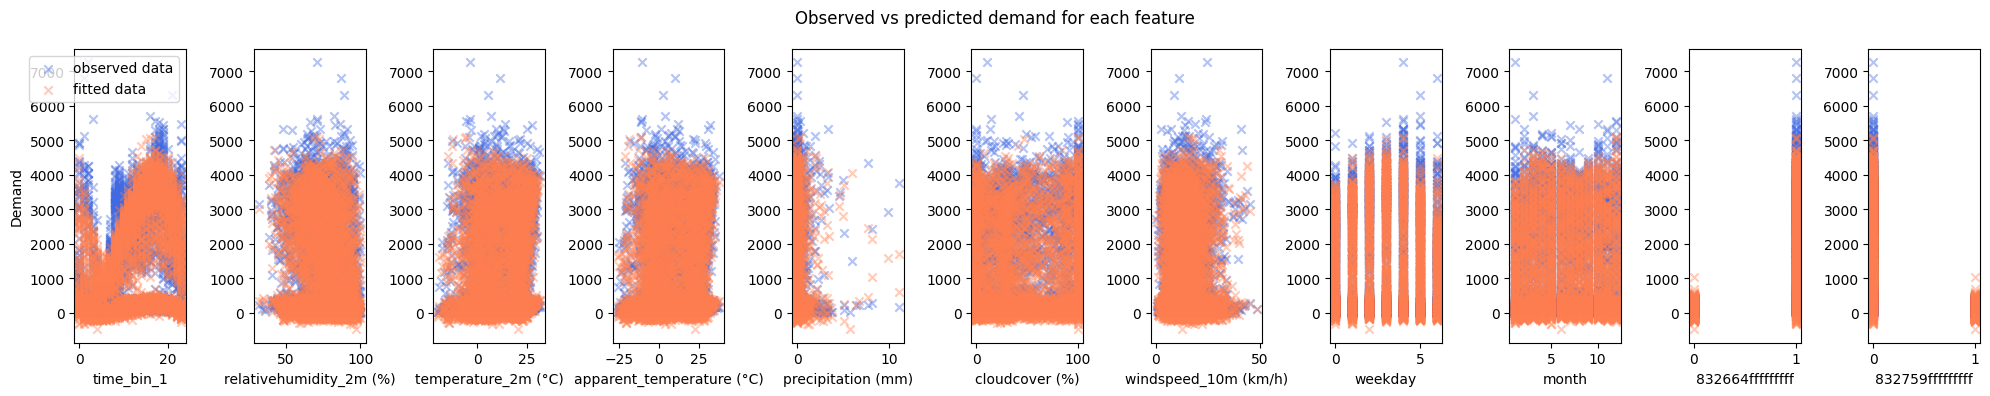

In [15]:
svr = SVR(kernel='rbf', epsilon=200 , gamma='scale', C=10000)

# Fit the SVR model
svr.fit(X_train_norm, y_train)

# Predict on the test set
y_pred_test = svr.predict(X_test_norm)
y_pred_train = svr.predict(X_train_norm)

# Evaluate the model
result = get_metrics(y_train, y_pred_train, y_test, y_pred_test)
display(result)

# Plot 
plot_matrix(X_test, y_test, X_test, y_pred_test)

**Note**: The hexagon ids (83266ff... etc.) are also plotted as features, which you can see on the right side.

### 1.1 Fit SVR for different data

#### 1.1.1 Different Location Dimensions

**Note:** We only tested the model performance on h3 resolutions from 1 to 5. For a higher resolution fitting the model took to long (because of our limited computing power).

In [16]:
r2_test = []
mae_test = []
for resolution in range(1,6,1):
    result = eval_svr(resolution,1)
    r2_test.append(result["r2"]["test"])
    mae_test.append(result["MAE"]["test"])

In [17]:
df_eval_resolution = pd.DataFrame(
    {
        "resolution": list(range(1,6,1)),
        "r2": r2_test,
        "MAE": mae_test
    }
)

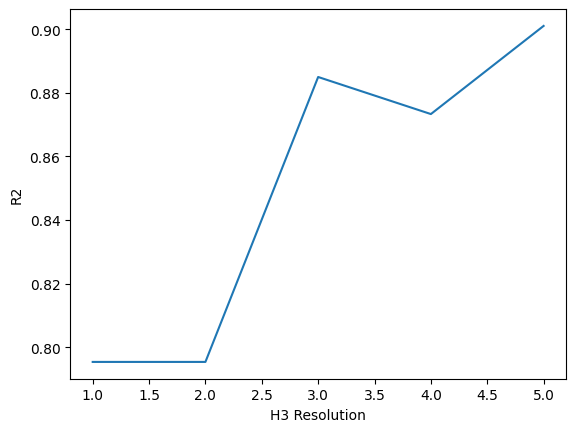

In [18]:
plt.plot(df_eval_resolution["resolution"], df_eval_resolution["r2"])
plt.xlabel("H3 Resolution")
plt.ylabel("R2")
plt.show()

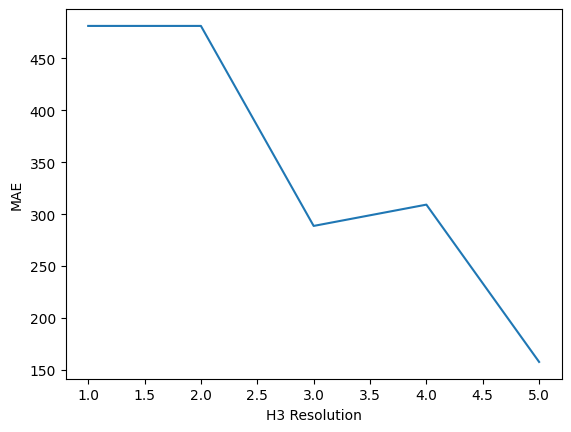

In [19]:
plt.plot(df_eval_resolution["resolution"], df_eval_resolution["MAE"])
plt.xlabel("H3 Resolution")
plt.ylabel("MAE")
plt.show()

**Important:** Looking at the MAE to compare the different model performances is not the best approach when you have different location and time resolutions. If the resolution is smaller, automatically the demand would be smaller and therefore the mean absolut error would tend to be smaller for these models.
For this reason, we focused on the R2 for the evaluation and the comparison of the model performance for different resolutions.

#### 1.1.2 Different Time Dimensions

In [20]:
r2_test = []
mae_test = []
for time_bins in [1,2,6,24]:
    result = eval_svr(3,time_bins)
    r2_test.append(result["r2"]["test"])
    mae_test.append(result["MAE"]["test"])

In [21]:
df_eval_time = pd.DataFrame(
    {
        "time_bins": [1,2,6,24],
        "r2": r2_test,
        "MAE": mae_test
    }
)

In [22]:
r2_test

[0.8849899675685381,
 0.8704248845550709,
 0.8769722111542113,
 0.9166274187919233]

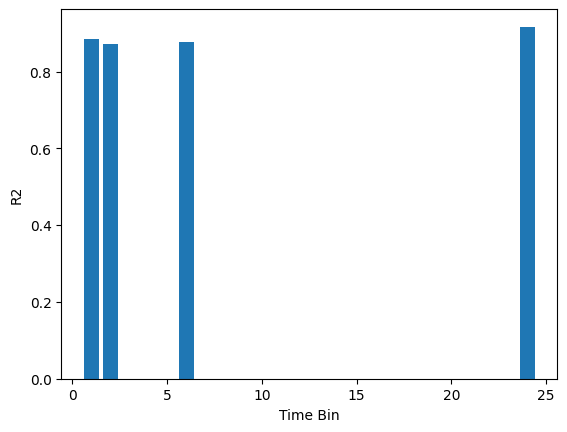

In [23]:
plt.bar(df_eval_time["time_bins"], df_eval_time["r2"])
plt.xlabel("Time Bin")
plt.ylabel("R2")
plt.show()

### 1.2 Fit SVR with POI as feature

#### 1.2.1 SVR with only one aggregated number of POI for each location

We first added the aggregated number of points of interest for each hexagon/census tract and used it as an additional feature.

In [24]:
poi_by_hex = get_n_poi_for_resolution()

/Users/yassinehammou/Documents/Uni Koeln/Master/2. Semester/AAA/Team Project/AAA_intentionally_blank/myenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [25]:
poi_by_hex

,h3_3,n_poi
0,832664fffffffff,827442
1,832759fffffffff,1260


In [26]:
df_poi = df.merge(poi_by_hex, how="left", on="h3_3")

In [27]:
# split whole data
X_train_norm, X_test_norm, X_val_norm, y_train, y_test, y_val, X_train, X_test, X_val = prep_data(df_poi, True, 3, False)

{'MAE': {'train': 267.6894795561388, 'test': 289.0706957389527},
 'r2': {'train': 0.9046565285861593, 'test': 0.8831757360652284}}

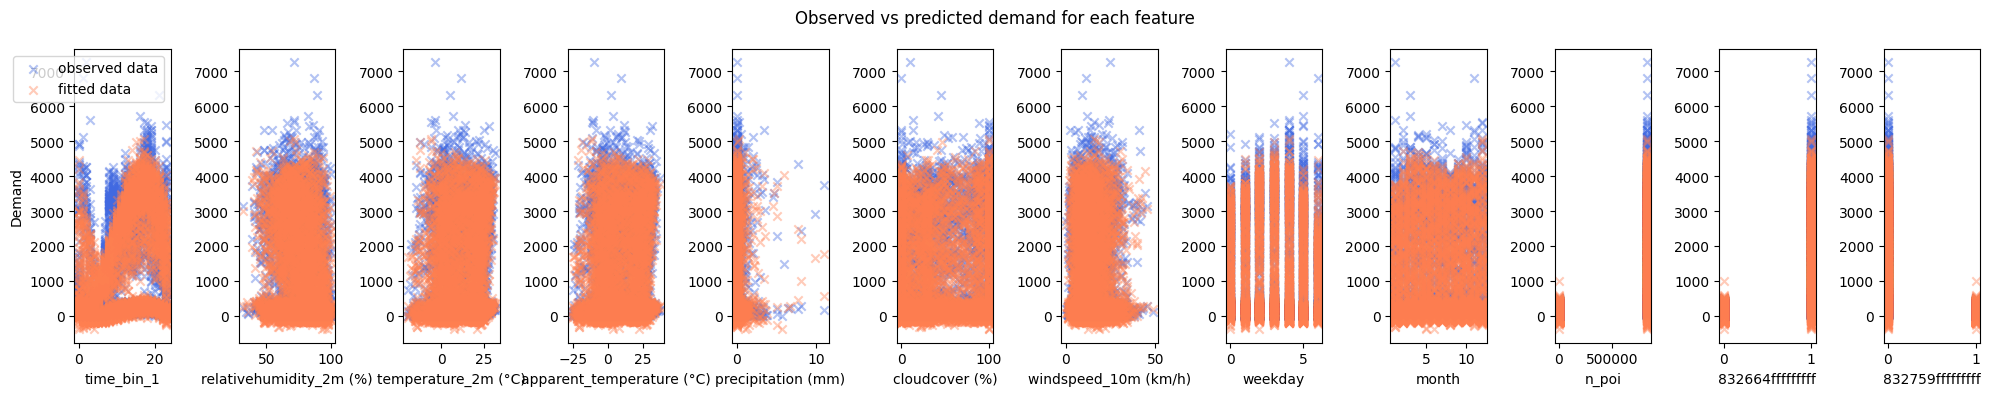

In [28]:
svr = SVR(kernel='rbf', epsilon=200 , gamma='scale', C=10000)

# Fit the SVR model
svr.fit(X_train_norm, y_train)

# Predict on the test set
y_pred_test = svr.predict(X_test_norm)
y_pred_train = svr.predict(X_train_norm)

# Evaluate the model
result = get_metrics(y_train, y_pred_train, y_test, y_pred_test)
display(result)

# Plot 
plot_matrix(X_test, y_test, X_test, y_pred_test)

The performance of the model remained nearly unchanged for this specific location and time resolution.
Now we want to look at different location resolutions.

In [29]:
r2_test = []
mae_test = []
for resolution in range(1,6,1):
    result = eval_svr(resolution,1, True)
    r2_test.append(result["r2"]["test"])
    mae_test.append(result["MAE"]["test"])

/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/954395966.py:4: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  result = eval_svr(resolution,1, True)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/954395966.py:4: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  result = eval_svr(resolution,1, True)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/954395966.py:4: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  result = eval_svr(resolution,1, True)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/954395966.py:4: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  result = eval_svr(

In [30]:
df_eval_resolution = pd.DataFrame(
    {
        "resolution": list(range(1,6,1)),
        "r2": r2_test,
        "MAE": mae_test
    }
)

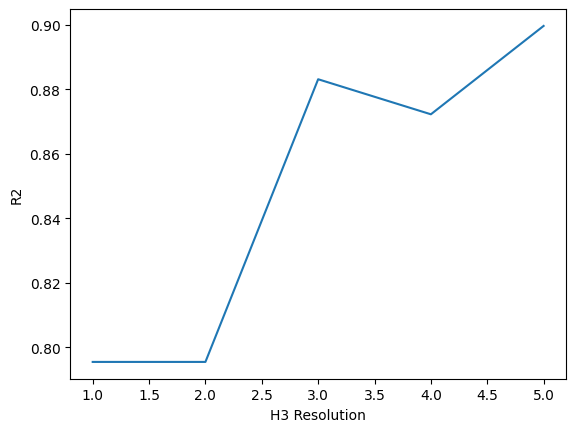

In [31]:
plt.plot(df_eval_resolution["resolution"], df_eval_resolution["r2"])
plt.xlabel("H3 Resolution")
plt.ylabel("R2")
plt.show()

Let us evaluate if we can leave out the location information (to which hexagon a data point belongs).

In [32]:
r2_test = []
mae_test = []
for resolution in range(1,6,1):
    result = eval_svr(resolution,1, True, location_info=False)
    r2_test.append(result["r2"]["test"])
    mae_test.append(result["MAE"]["test"])

/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/1992859719.py:4: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  result = eval_svr(resolution,1, True, location_info=False)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/1992859719.py:4: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  result = eval_svr(resolution,1, True, location_info=False)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/1992859719.py:4: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  result = eval_svr(resolution,1, True, location_info=False)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/1992859719.py:4: FutureWarning: The `op` parameter is deprecated and will be removed in a future release.

In [33]:
df_eval_resolution = pd.DataFrame(
    {
        "resolution": list(range(1,6,1)),
        "r2": r2_test,
        "MAE": mae_test
    }
)

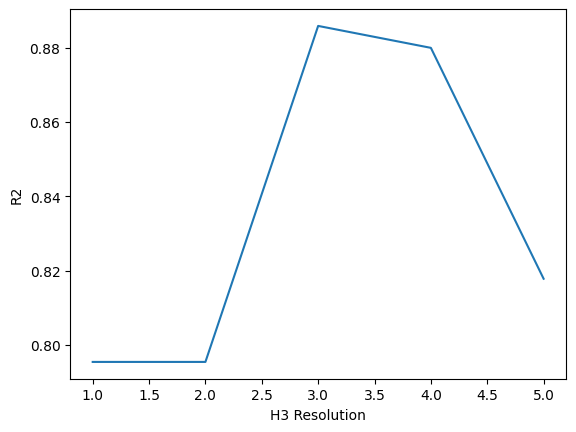

In [34]:
plt.plot(df_eval_resolution["resolution"], df_eval_resolution["r2"])
plt.xlabel("H3 Resolution")
plt.ylabel("R2")
plt.show()

The model performance drop for higher resolution if we let out the location information. Thus the aggregated point of interest are not sufficient to indirectly get locational information.

#### 1.2.2 SVR with multiple seperate POI for each location

Now we want to try different to use different point of interest features and not only one aggregated feature (e.g. number of bars, number of colleges) 

In [35]:
poi_by_hex = get_n_poi_for_resolution_and_amenity()

/Users/yassinehammou/Documents/Uni Koeln/Master/2. Semester/AAA/Team Project/AAA_intentionally_blank/myenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3508: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [36]:
poi_by_hex

,h3_3,bar,bus_station,car_rental,car_sharing,clinic,college,ferry_terminal,hospital,pharmacy,pub,university
0,832664fffffffff,466884,2970,18414,1782,50490,2376,23166,1188,55242,52866,5346
1,832759fffffffff,450,18,162,0,36,0,0,0,72,90,18


In [37]:
df_poi = df.merge(poi_by_hex, how="left", on="h3_3")

In [38]:
# split whole data
X_train_norm, X_test_norm, X_val_norm, y_train, y_test, y_val, X_train, X_test, X_val = prep_data(df_poi, True, 3, False)

In [39]:
svr = SVR(kernel='rbf', epsilon=200 , gamma='scale', C=10000)

# Fit the SVR model
svr.fit(X_train_norm, y_train)

# Predict on the test set
y_pred_test = svr.predict(X_test_norm)
y_pred_train = svr.predict(X_train_norm)

# Evaluate the model
result = get_metrics(y_train, y_pred_train, y_test, y_pred_test)
display(result)

{'MAE': {'train': 295.3350608814275, 'test': 304.0985765828203},
 'r2': {'train': 0.8785830448758944, 'test': 0.8633085556421771}}

In [40]:
# test for different resolutions

In [41]:
r2_test = []
mae_test = []
for resolution in range(1,6,1):
    result = eval_svr(resolution,1, False, True)
    r2_test.append(result["r2"]["test"])
    mae_test.append(result["MAE"]["test"])

/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/2548297801.py:4: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  result = eval_svr(resolution,1, False, True)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/2548297801.py:4: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  result = eval_svr(resolution,1, False, True)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/2548297801.py:4: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  result = eval_svr(resolution,1, False, True)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/2548297801.py:4: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter inst

In [42]:
df_eval_resolution = pd.DataFrame(
    {
        "resolution": list(range(1,6,1)),
        "r2": r2_test,
        "MAE": mae_test
    }
)

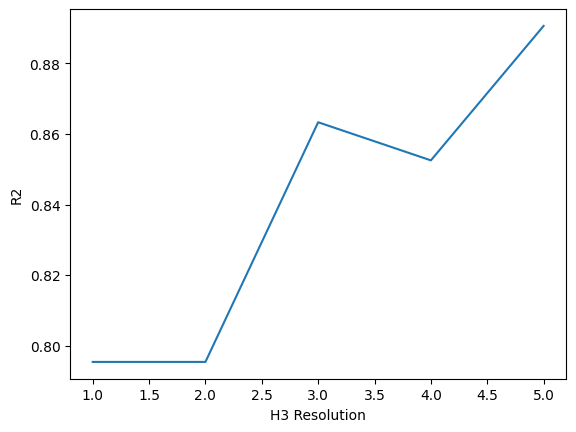

In [43]:
plt.plot(df_eval_resolution["resolution"], df_eval_resolution["r2"])
plt.xlabel("H3 Resolution")
plt.ylabel("R2")
plt.show()

Let us again evaluate if we can let out the location info!

In [44]:
r2_test = []
mae_test = []
for resolution in range(1,6,1):
    result = eval_svr(resolution,1, False, True, location_info=False)
    r2_test.append(result["r2"]["test"])
    mae_test.append(result["MAE"]["test"])

/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/3055755749.py:4: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  result = eval_svr(resolution,1, False, True, location_info=False)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/3055755749.py:4: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  result = eval_svr(resolution,1, False, True, location_info=False)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/3055755749.py:4: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  result = eval_svr(resolution,1, False, True, location_info=False)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/3055755749.py:4: FutureWarning: The `op` parameter is deprecated and will be removed

In [45]:
df_eval_resolution = pd.DataFrame(
    {
        "resolution": list(range(1,6,1)),
        "r2": r2_test,
        "MAE": mae_test
    }
)

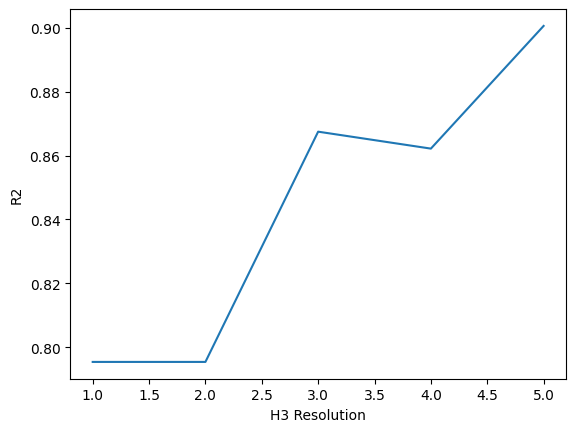

In [46]:
plt.plot(df_eval_resolution["resolution"], df_eval_resolution["r2"])
plt.xlabel("H3 Resolution")
plt.ylabel("R2")
plt.show()

## 2. Neural Network

In [47]:
def get_dl(batch_size, X_train_norm, X_test_norm, y_train, y_test):
    '''Generate tensors from data and initialize dataloader.'''
    
    X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_norm, dtype=torch.float32)
    
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

    # Create a DataLoader for batching and shuffling your data during training
    train_ds = TensorDataset(X_train_tensor, y_train_tensor)
    test_ds = TensorDataset(X_test_tensor, y_test_tensor)

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True) 
    
    return (train_dl, test_dl), (X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor)

In [48]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(FeedforwardNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()
  

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [49]:
def train(model, optimizer, train_dl, val_dl, epochs, loss_func, train_progress=True):
    '''Definition of the training loop of the neural network'''
    if train_progress:
        print("epoch  |    train loss   |  val loss ")
    
    for epoch in range(epochs):
        model.train()  # Set the model to train mode
        total_loss = 0
        
        for x, y in train_dl:
            x = x.to(device)
            y = y.to(device)

            # Forward pass
            y_hat = model(x)
            loss = loss_func(y_hat.flatten(), y)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        total_loss /= len(train_dl)

        # Validation
        model.eval()  # Set the model to evaluation mode
        total_loss_val = 0

        with torch.no_grad():
            for x, y in val_dl:
                x = x.to(device)
                y = y.to(device)

                y_hat = model(x)
                loss = loss_func(y_hat.flatten(), y)


                total_loss_val += loss.item()

            total_loss_val /= len(val_dl)
        
        if train_progress:    
            print("---------------------------------------------------")
            print(f"  {epoch}    |    {total_loss:.4f}  |  {total_loss_val:.4f}")

In [50]:
def nn_eval(model, X_train_tensor, X_test_tensor, X_test, y_train, y_test, display=True):
    """
    Evaluate a Neural Network model's performance on the test data and provide evaluation metrics.

    Parameters:
        model (torch.nn.Module): The trained Neural Network model to be evaluated.
        X_train_tensor (torch.Tensor): The tensor containing the normalized training features data.
        X_test_tensor (torch.Tensor): The tensor containing the normalized test features data.
        X_test (numpy.ndarray): The test features data before normalization (for reference).
        y_train (numpy.ndarray): The training labels data.
        y_test (numpy.ndarray): The test labels data.
        display (bool, optional): If True, plot the observed vs. predicted demand using the 'plot_matrix' function. Default is True.

    Returns:
        dict: A dictionary containing evaluation metrics for the Neural Network model's performance on the training and test datasets.
            The keys of the dictionary represent the evaluation metrics, and the values are dictionaries with evaluation results.
            Refer to the 'get_metrics' function for the specific format of the result dictionary.
    """
    model.eval()
    with torch.no_grad():
          y_pred_train = model(X_train_tensor.to(device))
          y_pred_test = model(X_test_tensor.to(device))

    y_pred_train = y_pred_train.cpu().numpy()
    y_pred_test = y_pred_test.cpu().numpy()


    # Evaluate the model
    result = get_metrics(y_train, y_pred_train, y_test, y_pred_test)
    
    if display:
        # Plot 
        plot_matrix(X_test, y_test, X_test, y_pred_test)
    
    return result

In [51]:
def eval_nn_for_different_resolutions(poi_agg, poi, output_size=1, learning_rate=0.05, batch_size=32, epochs=20, loss_func=nn.MSELoss(), location_info=True):
    """
    Evaluate a Neural Network model's performance for different hexagonal resolutions using different dataset configurations.

    Parameters:
        poi_agg (bool): If True, include aggregated Points of Interest (POI) data in the dataset.
        poi (bool): If True, include specific Points of Interest (POI) data for each amenity in the dataset.
        output_size (int, optional): The size of the output layer of the Neural Network model. Default is 1.
        learning_rate (float, optional): The learning rate for the optimization algorithm. Default is 0.05.
        batch_size (int, optional): The batch size for training the Neural Network. Default is 32.
        epochs (int, optional): The number of epochs (training iterations) for the Neural Network model. Default is 20.
        loss_func (torch.nn.Module, optional): The loss function used for training the Neural Network. Default is nn.MSELoss().
        location_info (bool, optional): If True, include location information in the dataset. Default is True.

    Returns:
        tuple: A tuple containing two lists:
            - r2 (list): A list of R-squared scores for the Neural Network model's performance on different resolutions.
            - mae (list): A list of Mean Absolute Errors (MAE) for the Neural Network model's performance on different resolutions.
    """
    r2 = []
    mae = []
    for resolution in range(1,7,1):
        path = f"data/04_predictive_analytics_data/prep_data/h3_{resolution}/h3_{resolution}_time_bin_1.csv"


        # load the data
        df = pd.read_csv(path, index_col=[0]).dropna()

        # add points of interest feature
        
        if poi_agg:
            poi_by_hex = get_n_poi_for_resolution(f"h3_{resolution}")
            df = df.merge(poi_by_hex, how="left", on=f"h3_{resolution}")
        elif poi:
            poi_by_hex = get_n_poi_for_resolution_and_amenity(f"h3_{resolution}")
            df = df.merge(poi_by_hex, how="left", on=f"h3_{resolution}")

        # split whole data
        X_train_norm, X_test_norm, _, y_train, y_test, __, X_train, X_test, X_val = prep_data(df, True, resolution, False, location_info=location_info)

        # generate dataloader
        (train_dl, test_dl), (X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor) = get_dl(batch_size, X_train_norm, X_test_norm, y_train, y_test)

        # get model
        model = FeedforwardNN(X_train_norm.shape[1], output_size)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)

        # train model
        train(model, optimizer, train_dl, test_dl, epochs, loss_func, False)

        # eval model
        result = nn_eval(model, X_train_tensor, X_test_tensor, X_test, y_train, y_test, False)
        r2.append(result["r2"]["test"])
        mae.append(result["MAE"]["test"])
        
    return r2, mae

In [52]:
# Define the hyperparameters
output_size = 1  # Number of output neurons

learning_rate = 0.05
batch_size = 32
epochs = 20

loss_func = nn.MSELoss()

epoch  |    train loss   |  val loss 


---------------------------------------------------
  0    |    789676.4927  |  669823.7999
---------------------------------------------------
  1    |    692560.3023  |  615219.1268
---------------------------------------------------
  2    |    503922.4512  |  407908.3272
---------------------------------------------------
  3    |    365695.9727  |  357124.0494
---------------------------------------------------
  4    |    289879.4801  |  283847.4631
---------------------------------------------------
  5    |    241228.9293  |  245796.0825
---------------------------------------------------
  6    |    227691.7336  |  377984.8319
---------------------------------------------------
  7    |    226637.5740  |  229504.1863
---------------------------------------------------
  8    |    211540.1085  |  188010.7476
---------------------------------------------------
  9    |    198118.1084  |  170223.7384
---------------------------------------------------
  10    |    176598.6823  | 

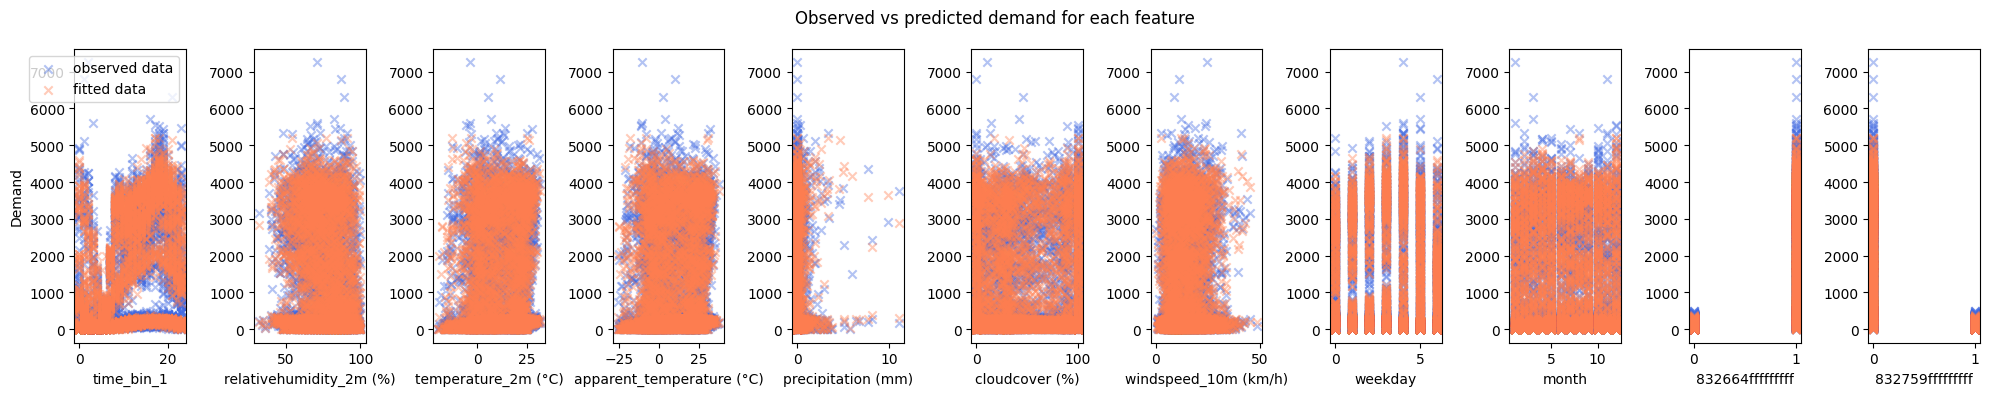

In [53]:
# load the data
df = pd.read_csv(f"data/04_predictive_analytics_data/prep_data/h3_3/h3_3_time_bin_1.csv", index_col=[0]).dropna()

# split whole data
X_train_norm, X_test_norm, _, y_train, y_test, __, X_train, X_test, X_val = prep_data(df, True, 3, False)

# generate dataloader
(train_dl, test_dl), (X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor) = get_dl(batch_size, X_train_norm, X_test_norm, y_train, y_test)


# get model
model = FeedforwardNN(X_train_norm.shape[1], output_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# train model
train(model, optimizer, train_dl, test_dl, epochs, loss_func)

# eval model
result = nn_eval(model, X_train_tensor, X_test_tensor, X_test, y_train, y_test, True)

In [55]:
print(result)

{'MAE': {'train': 191.31452403737987, 'test': 201.55154924866156}, 'r2': {'train': 0.9422077246754591, 'test': 0.9293796551542137}}


### 2.1 Fit NN for different data

#### 2.1.1 Different Location Dimensions

In [56]:
r2, mae = eval_nn_for_different_resolutions(False, False)

In [57]:
r2

[0.8422518741997879,
 0.789950197919234,
 0.9221653218905916,
 0.9241804187702314,
 0.9489358826140663,
 0.9576872777859515]

In [58]:
df_eval_resolution = pd.DataFrame(
    {
        "resolution": list(range(1,7,1)),
        "r2": r2,
        "MAE": mae
    }
)

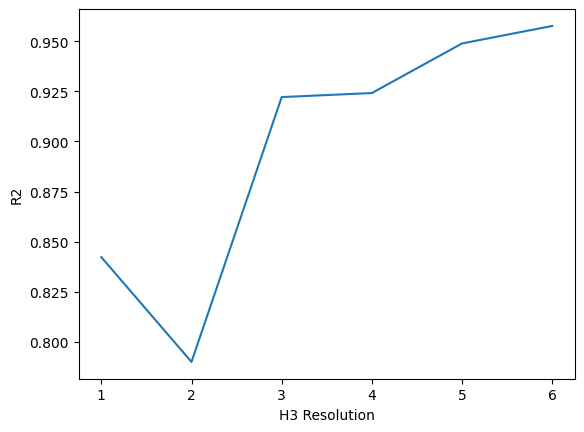

In [59]:
plt.plot(df_eval_resolution["resolution"], df_eval_resolution["r2"])
plt.xlabel("H3 Resolution")
plt.ylabel("R2")
plt.show()

#### 2.1.2 Different Time Dimensions

In [60]:
# Define the hyperparameters
input_size = 10  # Number of input features
output_size = 1  # Number of output neurons

learning_rate = 0.05
batch_size = 32
epochs = 20

loss_func = nn.MSELoss()

In [61]:
r2 = []
mae = []
for time_bin in [1,2,6,24]:
    path = f"data/04_predictive_analytics_data/prep_data/h3_3/h3_3_time_bin_{time_bin}.csv"
    
    
    # load the data
    df = pd.read_csv(path, index_col=[0]).dropna()

    # split whole data
    X_train_norm, X_test_norm, _, y_train, y_test, __, X_train, X_test, X_val = prep_data(df, True, 3, False)

    # generate dataloader
    (train_dl, test_dl), (X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor) = get_dl(batch_size, X_train_norm, X_test_norm, y_train, y_test)

    # get model
    model = FeedforwardNN(X_train_norm.shape[1], output_size)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # train model
    train(model, optimizer, train_dl, test_dl, epochs, loss_func, False)

    # eval model
    result = nn_eval(model, X_train_tensor, X_test_tensor, X_test, y_train, y_test, False)
    r2.append(result["r2"]["test"])
    mae.append(result["MAE"]["test"])

In [62]:
r2

[0.9267586611762918, 0.9093795786826129, 0.813840317956581, 0.8655445900880472]

In [63]:
df_eval_resolution = pd.DataFrame(
    {
        "time_bins": [1,2,6,24],
        "r2": r2,
        "MAE": mae
    }
)

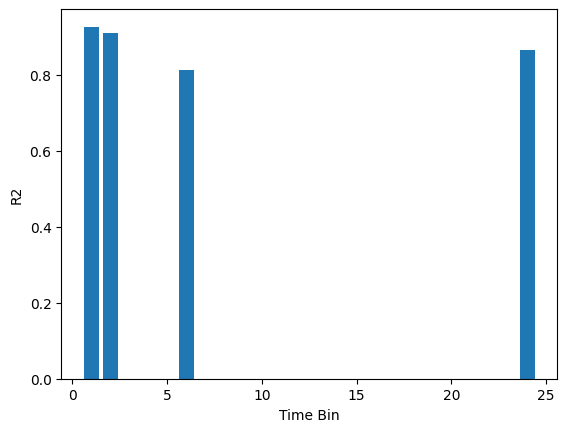

In [64]:
plt.bar(df_eval_resolution["time_bins"], df_eval_resolution["r2"])
plt.xlabel("Time Bin")
plt.ylabel("R2")
plt.show()

### 2.2 Fit on data where zero demand is allowed

In [65]:
# load data
df = pd.read_csv("04_predictive_analytics_data/h3_5_time_bin_1_zero.csv", index_col=[0]).drop(columns=["time", "hour"])

epoch  |    train loss   |  val loss 
---------------------------------------------------
  0    |    125092.3534  |  93047.7445
---------------------------------------------------
  1    |    61177.8616  |  47520.3004
---------------------------------------------------
  2    |    49415.5574  |  66077.4449
---------------------------------------------------
  3    |    46184.8707  |  45701.1444
---------------------------------------------------
  4    |    43367.1259  |  39386.1438
---------------------------------------------------
  5    |    41254.7379  |  39067.5055
---------------------------------------------------
  6    |    38907.0275  |  40969.6925
---------------------------------------------------
  7    |    38168.5840  |  33347.4677
---------------------------------------------------
  8    |    37354.9866  |  31931.8259
---------------------------------------------------
  9    |    35846.5478  |  35559.5266
---------------------------------------------------
  10    |

/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/1205180188.py:57: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


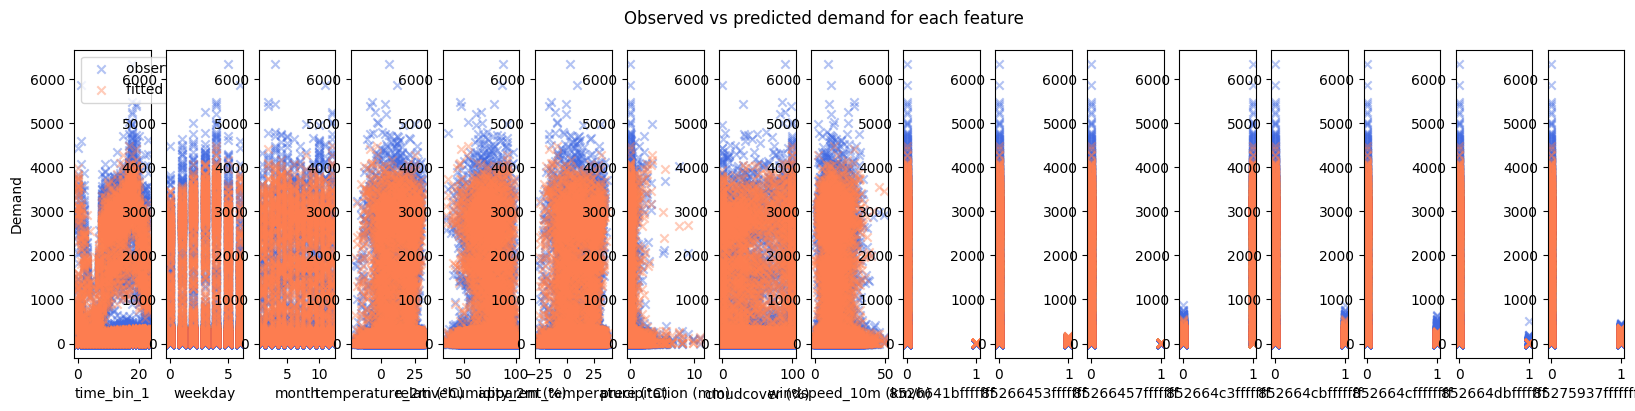

In [66]:
# split whole data
X_train_norm, X_test_norm, _, y_train, y_test, __, X_train, X_test, ___ = prep_data(df, True, 5, False)

# generate dataloader
(train_dl, test_dl), (X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor) = get_dl(batch_size, X_train_norm, X_test_norm, y_train, y_test, )


# get model
model = FeedforwardNN(X_train_norm.shape[1], output_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# train model
train(model, optimizer, train_dl, test_dl, epochs, loss_func)

# eval model
result = nn_eval(model, X_train_tensor, X_test_tensor, X_test, y_train, y_test, True)

In [67]:
print(result)

{'MAE': {'train': 59.45222210557414, 'test': 60.72504751492967}, 'r2': {'train': 0.957653362658891, 'test': 0.9555690786653667}}


Allowing a trip demand of zero does not allow for better performance.

### 2.3 Fit NN with POI as feature

#### 2.3.1 NN with only one aggregated number of POI for each location

In [68]:
r2, mae = eval_nn_for_different_resolutions(True, False)

/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/4049416234.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  r2, mae = eval_nn_for_different_resolutions(True, False)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/4049416234.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  r2, mae = eval_nn_for_different_resolutions(True, False)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/4049416234.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  r2, mae = eval_nn_for_different_resolutions(True, False)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/4049416234.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Pleas

In [69]:
df_eval_resolution = pd.DataFrame(
    {
        "resolution": list(range(1,7,1)),
        "r2": r2,
        "MAE": mae
    }
)

In [70]:
df_eval_resolution

,resolution,r2,MAE
0,1,0.824824,428.627672
1,2,0.829956,448.006405
2,3,0.915194,229.363251
3,4,0.915146,227.182968
4,5,0.948333,84.148405
5,6,0.957115,65.418053


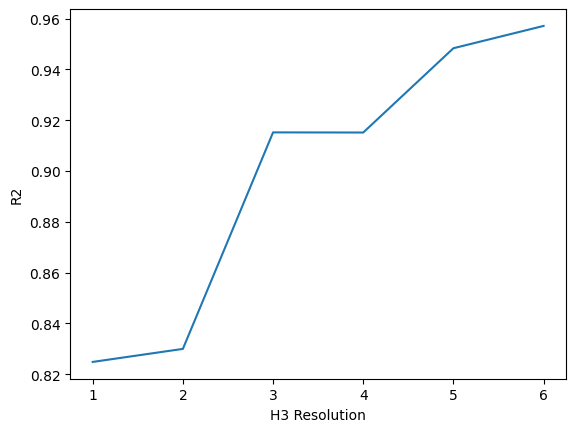

In [71]:
plt.plot(df_eval_resolution["resolution"], df_eval_resolution["r2"])
plt.xlabel("H3 Resolution")
plt.ylabel("R2")
plt.show()

Test model performance without location info!

In [72]:
r2, mae = eval_nn_for_different_resolutions(True, False, location_info=False)

/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/352790658.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  r2, mae = eval_nn_for_different_resolutions(True, False, location_info=False)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/352790658.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  r2, mae = eval_nn_for_different_resolutions(True, False, location_info=False)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/352790658.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  r2, mae = eval_nn_for_different_resolutions(True, False, location_info=False)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/352790658.py:1: FutureWarning: The `op` parameter i

In [73]:
df_eval_resolution = pd.DataFrame(
    {
        "resolution": list(range(1,7,1)),
        "r2": r2,
        "MAE": mae
    }
)

In [74]:
df_eval_resolution

,resolution,r2,MAE
0,1,0.836171,409.542940
1,2,0.790153,485.040013
2,3,0.923475,214.036423
3,4,0.923366,206.128610
4,5,0.947725,93.788804
5,6,0.944091,86.199290


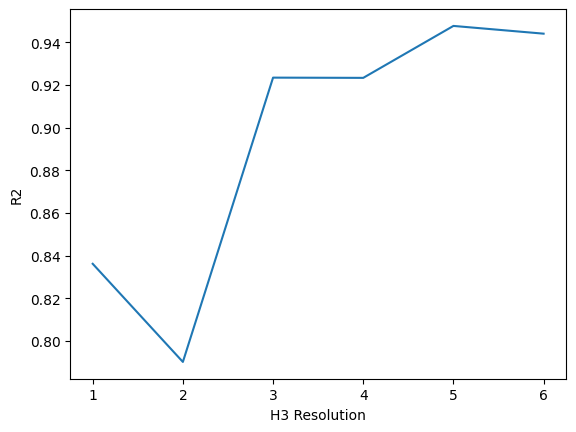

In [75]:
plt.plot(df_eval_resolution["resolution"], df_eval_resolution["r2"])
plt.xlabel("H3 Resolution")
plt.ylabel("R2")
plt.show()

#### 2.3.2 NN with multiple seperate POI for each locations

In [76]:
r2, mae = eval_nn_for_different_resolutions(False, True)

/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/3870951707.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  r2, mae = eval_nn_for_different_resolutions(False, True)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/3870951707.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  r2, mae = eval_nn_for_different_resolutions(False, True)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/3870951707.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  r2, mae = eval_nn_for_different_resolutions(False, True)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/3870951707.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Pleas

In [77]:
df_eval_resolution = pd.DataFrame(
    {
        "resolution": list(range(1,7,1)),
        "r2": r2,
        "MAE": mae
    }
)

In [78]:
df_eval_resolution

,resolution,r2,MAE
0,1,0.791798,474.854275
1,2,0.848030,406.189111
2,3,0.882216,274.748722
3,4,0.906507,230.209115
4,5,0.942887,87.101189
5,6,0.953073,64.294755


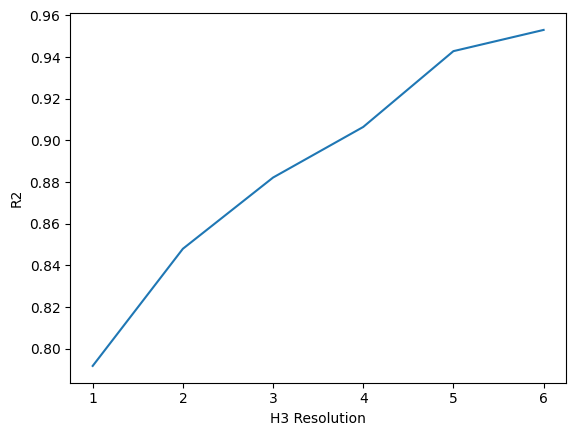

In [79]:
plt.plot(df_eval_resolution["resolution"], df_eval_resolution["r2"])
plt.xlabel("H3 Resolution")
plt.ylabel("R2")
plt.show()

Test model performance without location info!

In [80]:
r2, mae = eval_nn_for_different_resolutions(False, True, location_info=False)

/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/36565965.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  r2, mae = eval_nn_for_different_resolutions(False, True, location_info=False)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/36565965.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  r2, mae = eval_nn_for_different_resolutions(False, True, location_info=False)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/36565965.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  r2, mae = eval_nn_for_different_resolutions(False, True, location_info=False)
/var/folders/ch/yj3xbk4s1t34gtb89jtxcmcr0000gn/T/ipykernel_7045/36565965.py:1: FutureWarning: The `op` parameter is de

In [81]:
df_eval_resolution = pd.DataFrame(
    {
        "resolution": list(range(1,7,1)),
        "r2": r2,
        "MAE": mae
    }
)

In [82]:
df_eval_resolution

,resolution,r2,MAE
0,1,0.807815,450.677390
1,2,0.822998,423.319330
2,3,0.924217,210.340677
3,4,0.915021,220.942926
4,5,0.942885,91.111467
5,6,0.933085,83.157144


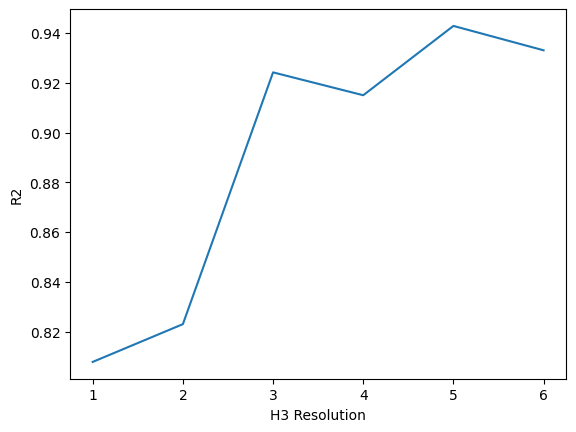

In [83]:
plt.plot(df_eval_resolution["resolution"], df_eval_resolution["r2"])
plt.xlabel("H3 Resolution")
plt.ylabel("R2")
plt.show()

#### 2.3.3 NN for census tract demand prediction without location info but point of interest info

In [84]:
census_tract_borders = gpd.read_file("data/04_predictive_analytics_data/chicago_census_tract_borders.zip")

In [85]:
census_tract_borders = census_tract_borders.drop(census_tract_borders.columns.difference(["GEOID", "geometry"]), axis=1)
census_tract_borders.crs = "EPSG:4326"
census_tract_borders = census_tract_borders.to_crs("EPSG:4326")

In [86]:

path = "data/04_predictive_analytics_data/prep_data/pickup_census_tract/pickup_census_tract_time_bin_1.csv"


# load the data
df = pd.read_csv(path, index_col=[0]).dropna()

# add points of interest feature

 # load point of interest
poi = gpd.read_file("data/04_predictive_analytics_data/POI.geojson")

# join
poi_by_census_tract = gpd.sjoin(poi, census_tract_borders, how='inner', op='within').groupby(["GEOID", "amenity"]).size().to_frame().reset_index()

# generate according dataframe with features
poi_features = []
for census_tract in poi_by_census_tract["GEOID"].unique():
    di = {"pickup_census_tract": census_tract}
    for amenity in poi_by_census_tract.amenity.unique():
        n = poi_by_census_tract[(poi_by_census_tract["GEOID"] == census_tract) & (poi_by_census_tract["amenity"] == amenity)][0].values
        di[amenity] = n[0] if n.size > 0 else 0
    poi_features.append(di)

poi_by_census_tract = pd.DataFrame(poi_features)

poi_by_census_tract.pickup_census_tract = poi_by_census_tract.pickup_census_tract.astype("int64")
df = df.merge(poi_by_census_tract, how="left", on="pickup_census_tract")
df = df.drop(columns="pickup_census_tract")

# split whole data
X_train_norm, X_test_norm, _, y_train, y_test, __, X_train, X_test, X_val = prep_data(df, train_test_val_split=False)

# generate dataloader
(train_dl, test_dl), (X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor) = get_dl(batch_size, X_train_norm, X_test_norm, y_train, y_test)

# get model
model = FeedforwardNN(X_train_norm.shape[1], output_size)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# train model
train(model, optimizer, train_dl, test_dl, epochs, loss_func, False)

# eval model
result = nn_eval(model, X_train_tensor, X_test_tensor, X_test, y_train, y_test, False)

/Users/yassinehammou/Documents/Uni Koeln/Master/2. Semester/AAA/Team Project/AAA_intentionally_blank/myenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [87]:
print(result)

{'MAE': {'train': 19.852842750407856, 'test': 19.854190687362053}, 'r2': {'train': 0.8458045900879176, 'test': 0.8467199209100612}}
